<a href="https://colab.research.google.com/github/wandb/awesome-dl-projects/blob/master/ml-tutorial/EMNIST_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setups

In [ ]:
!nvidia-smi

Sat Aug 29 14:18:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
tfds.disable_progress_bar()

import csv
import string
import pathlib
import gzip
from tqdm import tqdm
import seaborn as sns
from itertools import groupby

from sklearn.utils import shuffle

2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Download Dataset

#### Wiki-split dataset

In [ ]:
!git clone https://github.com/google-research-datasets/wiki-split

Cloning into 'wiki-split'...
remote: Enumerating objects: 32, done.
remote: Total 32 (delta 0), reused 0 (delta 0), pack-reused 32
Unpacking objects: 100% (32/32), done.


> Side Note: We will be using `test.tsv` for our experiment to speed up the process.

#### EMNIST/Bymerge Dataset

In [ ]:
# Gather EMNIST/bymerge dataset
train_ds, validation_ds = tfds.load(
    "emnist/bymerge",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/emnist/bymerge/3.0.0.incompleteAJ93PF/emnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/emnist/bymerge/3.0.0.incompleteAJ93PF/emnist-test.tfrecord
Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/bymerge/3.0.0. Subsequent calls will reuse this data.


# Load Data, Clean it and preprocess

In [ ]:
raw_sentences = []  # empty list to store sentences
with open("wiki-split/test.tsv", "r") as f:
    reader = csv.reader(f, delimiter='\t')  # read a tsv file
    for row in tqdm(reader):
        raw_sentences.extend(row[1].split("<::::>"))
print("Total Sentences: ", len(raw_sentences))

5000it [00:00, 152616.71it/s]

Total Sentences:  10000


In [ ]:
# Some samples
print(raw_sentences[99], '\n', raw_sentences[100])

 He was was arrested and booked on charges of first - degree murder and first - degree robbery . 
 A 2006 estimate by the International Organization for Migration put the number of Sudanese people in the UK at a much higher figure . 


#### Remove punctuations

In [ ]:
# As we see there are lots of punctuations which we dont have in EMNIST, so we are going to remove them, 
# and replace multiple spaces with one
import re

sentences = []
table = str.maketrans({key: None for key in string.punctuation})  # translation table

for sentence in raw_sentences:
    # remove punctuation and non-ascii characters
    clean_sentence = re.sub('  +', ' ', sentence.translate(table)).\
                        encode("ascii", 'ignore').decode()  
    sentences.append(clean_sentence.strip())  # add to clean sentences
    
print(sentences[99], '\n', raw_sentences[99])  # to verify

He was was arrested and booked on charges of first degree murder and first degree robbery 
  He was was arrested and booked on charges of first - degree murder and first - degree robbery .


In [ ]:
print('Number of sentences', len(sentences))

Number of sentences 10000


#### EMNIST Labels

In [ ]:
MAPPINGS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

print(len(MAPPINGS))

47


#### Dataloader for EMNIST

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256

## We are transposing to rotate the image by 90 deg clockwise making the images human friendly.
def transpose(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32) # scale image pixels to [0,1]
  image = tf.transpose(image, [1,0,2]) # transpose to get human friendly image, since rotation
  return image, label

trainloader = (
    train_ds
    .shuffle(1024)
    .map(transpose, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

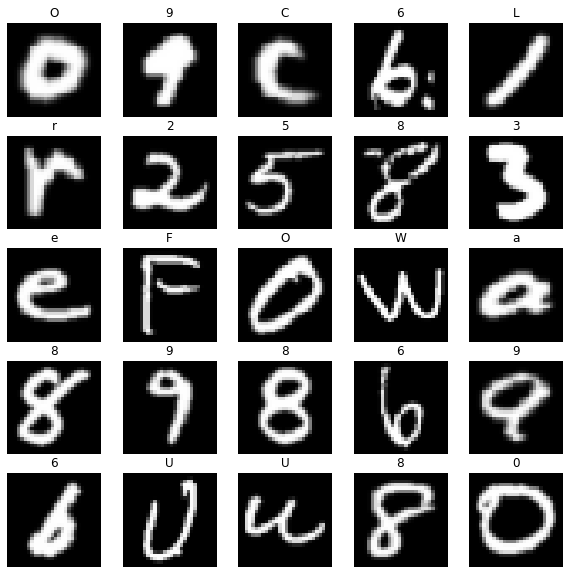

In [ ]:
plt.figure(figsize=(10, 10))
n = 0
for img, label in trainloader.take(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(tf.reshape(img, (28,28)), cmap='gray')
    plt.title(MAPPINGS[int(label.numpy())])
    plt.axis('off')
    n+=1

#### Get all the images in an array

In [ ]:
IMAGES = []
LABELS = []

for img, label in tqdm(trainloader):
    IMAGES.append(tf.reshape(img, (28,28)).numpy())
    LABELS.append(label.numpy())

IMAGES = np.array(IMAGES)
LABELS = np.array(LABELS)

593242it [08:08, 1214.91it/s]


#### Index Images

In [ ]:
image_index = {}  # where key is the char and value is a list of IDs
for idx, label in tqdm(enumerate(LABELS)):
    char = MAPPINGS[label]
    if char in image_index:
        # this character already exists
        image_index[char].append(idx) # append index
    else:
        image_index[char] = [idx]  # initiate list with 1 item

593242it [00:00, 1607713.51it/s]


# Utils to generate image from text

In [ ]:
def get_sample_sentences(sentences_in=sentences, num_sentence=10):
    # Get a defined number of sentences from the data
    return np.random.choice(sentences_in, num_sentence)

def get_generated_image(words, chars=IMAGES, index=image_index):
    # words is string of char/numbers that needs to be converted into an image
    # chars is a data set of images that need to be used to compose, usually pass in train['features'] in here
    # index maps a character to indexes in the images, available as dictionary
    height, width = IMAGES[0].shape # height and width of each character
    length = len(words) # total number of characters in the image
    
    # create an empty array to store the data
    image = np.zeros((height, width * length))
    pos = 0  # starting index of the character
    
    for char in words:
        if char is ' ':
            pos += width # if space, move over
        else:
            if char in image_index:
                # pick a random item from all images for that char
                idx = np.random.choice(image_index[char])  
                image[:, pos:(pos+width)] += chars[idx]
            elif char.upper() in image_index:  # to remove characters from other languages
                # for some characters, there is only upper case
                idx = np.random.choice(image_index[char.upper()])  
                image[:, pos:(pos+width)] += chars[idx]
            
            pos += width
    
    return image

#### Check one sample

['Dragon Day is an annual event at Cornell University that occurs in March']


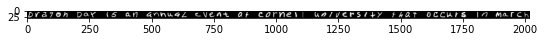

In [ ]:
# Let's print a sample to see how it looks
s = get_sample_sentences(sentences, 1)
print(s)
img = get_generated_image(s[0])
plt.figure(figsize=(9,2))
plt.imshow(img, cmap='gray')
plt.show()

# Build Training Dataset

In [ ]:
train_sentences = sentences[:2000]
test_sentences = sentences[2000:2500]

# Lets assume that for each training sample, 2 variants will be generated

def generate_sentences(texts, chars, 
                           index, num_variants=2, max_length=32):
    # this method takes input text lines, character samples and labels
    # and generates images. It can generate multiple images per sentence
    # as controlled by num_variants parameter. max_length parameter
    # ensures that all sentences are the same length
    
    # total number of samples to generate
    num_samples = len(texts) * num_variants
    height, width = chars[0].shape  # shape of image
    
    # setup empty array of the images
    images = np.zeros((num_samples, height, width * max_length), np.float64)
    labels = []
    
    for i, item in tqdm(enumerate(texts)):
        padded_item = item[0:max_length] if (len(item) > max_length) else item.ljust(max_length, ' ')
        
        for v in range(num_variants):
            img = get_generated_image(padded_item, chars, index)
            images[i*num_variants+v, :, :] += img
            labels.append(padded_item)
    
    return images, labels

In [ ]:
train_images, train_labels = generate_sentences(train_sentences, IMAGES, image_index)
test_images, test_labels = generate_sentences(test_sentences, IMAGES, image_index)

train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

2000it [02:29, 13.40it/s]
500it [00:37, 13.18it/s]


#### Check one sample

Because of his elegant football 


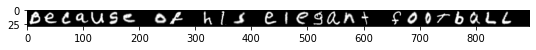

In [ ]:
# Sample some to check
idx=0
print(train_labels[idx])
plt.figure(figsize=(9,2))
plt.imshow(train_images[idx], cmap='gray');
plt.show()

#### Save Dataset

In [ ]:
# Now to save these models for easy loading
pp = pathlib.Path('.') / 'sentences'
pp.mkdir(exist_ok=True)  # create the directory

np.save(pp / 'train_images', train_images)
np.save(pp / 'test_images', test_images)
np.save(pp / 'train_labels', train_labels)
np.save(pp / 'test_labels', test_labels)

# Prepare Training Dataset(Label)

In [ ]:
# create a dictionary of mapping from 
mappings = dict(zip(np.arange(0, 47), MAPPINGS))
# add a space for spacing words
mappings[47] = ' '
# inverse: character as key and value as it's integer encoding
inverse_mappings = {v: k for k, v in mappings.items()}

In [ ]:
# now convert categorical labels from the sentences
encode = lambda x: [inverse_mappings[xi] if xi in inverse_mappings else inverse_mappings[xi.upper()] for xi in x]
decode = lambda x: [mappings[xi] for xi in x]

train_labels_cat = np.array([encode(xi) for xi in train_labels])
test_labels_cat = np.array([encode(xi) for xi in test_labels])

# Verify the encoding/decoding
print(train_labels[1])
print(train_labels_cat.shape, train_labels_cat[1])
print(decode(train_labels_cat[1]))

During the 2009 NRL season the N
(4000, 32) [13 30 45 18 43 41 47 46 42 39 47  2  0  0  9 47 23 27 21 47 28 39 36 28
 24 43 47 46 42 39 47 23]
['D', 'U', 'r', 'I', 'n', 'g', ' ', 't', 'h', 'e', ' ', '2', '0', '0', '9', ' ', 'N', 'R', 'L', ' ', 'S', 'e', 'a', 'S', 'O', 'n', ' ', 't', 'h', 'e', ' ', 'N']


# Build Train and Test Loader

Using `tf.data`

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

# This step will make sense after looking at the model
def merge_image_label(image, label):
    return (image, label), label

trainloader = tf.data.Dataset.from_tensor_slices((train_images, train_labels_cat))
testloader = tf.data.Dataset.from_tensor_slices((test_images, test_labels_cat))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(merge_image_label, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(merge_image_label, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Build Model

In [ ]:
# CNN definition : LeNet5 architecture, a classic architecture
IMG_H, IMG_W = train_images[1].shape
# we limited output sentences to 32 chars
OUTPUT_LENGTH = 32  
# EMNIST has 47 labels, adding one for 'blank space'
NUM_CLASSES = 49 # notice two additional class; one is for "space" another is required by "CTCLayer"

#### Utility to Extract Patch

Since each image is a sentence, we will extract patches from it
width of each patch will be 20 pixels wide (note EMNIST is 28 px)
and every time we will move 14 px over to extract another sample

In [ ]:
PATCH_WIDTH = 20
PATCH_STRIDE = 14

In [ ]:
def extract_patches(image):
    kernel = [1, 1, PATCH_WIDTH, 1]
    strides = [1, 1, PATCH_STRIDE, 1]
    patches = tf.image.extract_patches(image, kernel, strides, [1, 1, 1, 1], 'VALID')
    patches = tf.transpose(patches, (0, 2, 1, 3))
    patches = tf.expand_dims(patches, -1)
    return patches

#### CNN backbone

* Takes in a patch of image
* Returned flattened embedding

In [ ]:
def ImagePatchEncoder():
  patched_inputs = Input(shape=(IMG_H, PATCH_WIDTH, 1))
  x = Conv2D(32, kernel_size=(3, 3), activation='relu')(patched_inputs)
  x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.2)(x)
  flattened_outputs = Flatten()(x)

  return Model(inputs=patched_inputs, outputs=flattened_outputs, name='backbone')

tf.keras.backend.clear_session()
image_patch_encoder = ImagePatchEncoder()
image_patch_encoder.summary()

Model: "backbone"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 20, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 18, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 16, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 8, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 8, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
______________________________________________________

#### CTC Loss Layer

You can learn more about CTC Loss in this [awesome blog post](https://app.wandb.ai/authors/text-recognition-crnn-ctc/reports/Text-Recognition-with-CRNN-CTC-Network--VmlldzoxNTI5NDI).

In [ ]:
## Ref: https://keras.io/examples/vision/captcha_ocr/
class CTCLayer(Layer):
  def __init__(self, name=None):

      super().__init__(name=name)
      self.loss_fn = tf.keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
      # Compute the training-time loss value and add it
      # to the layer using `self.add_loss()`.

      batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
      input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
      label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

      input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
      label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

      loss = self.loss_fn(y_true, y_pred, input_length, label_length)
      self.add_loss(loss)

      # At test time, just return the computed predictions
      return y_pred
      

#### Final Model

##### Image Encoder

* Take in image input
* Get patches of shape `(PATCH_HEIGHT, PATCH_WIDTH, 1)`.
* Feed patches to backbone CNN architecture to get embedding. 
* Wrap using `TimeDistributed`


##### Recurrent Network

* Takes in `TimeDistributed` sequence
* Computes output

In [ ]:
def ImagetoSequence():
  # IMAGE ENCODER #
  labels = Input(name="label", shape=(None,), dtype="float32")
  image_input = Input(shape=(IMG_H, IMG_W), name="cnn_input")
  # reshape to add dimensions
  image_reshaped = Reshape((IMG_H, IMG_W, 1))(image_input)
  # extract patches of images
  image_patches = Lambda(extract_patches)(image_reshaped)
  # get CNN backbone architecture to get embedding for each patch
  image_patch_encoder = ImagePatchEncoder()
  # Wrapper allows to apply a layer to every temporal slice of an input.
  time_wrapper = TimeDistributed(image_patch_encoder)(image_patches)

  # RECURRENT NETWORK #
  lstm_out = LSTM(128, return_sequences=True, name="lstm")(time_wrapper)
  softmax_output = Dense(NUM_CLASSES, activation='softmax', name="lstm_softmax")(lstm_out)
  # 
  output = CTCLayer(name="ctc_loss")(labels, softmax_output)

  return Model([image_input, labels], output)

# Initialize Model

In [ ]:
tf.keras.backend.clear_session()
model = ImagetoSequence()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, 28, 896)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 896, 1)   0           cnn_input[0][0]                  
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 63, 28, 20, 1 0           reshape[0][0]                    
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 63, 6144)     18816       lambda[0][0]                     
_______________________________________________________________________________________

# Compile Model

In [ ]:
# compile the models
model.compile(tf.keras.optimizers.Adam())

# Train Model with W&B

In [ ]:
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True)

In [ ]:
wandb.init(entity='wandb', project='emnist')

_ = model.fit(trainloader,  
                    validation_data=testloader,
                    epochs=100,
                    callbacks=[WandbCallback(),
                               early_stopper])

Epoch 1/100
63/63 [==============================] - 12s 193ms/step - loss: 95.8657 - val_loss: 68.0317
Epoch 2/100
63/63 [==============================] - 11s 178ms/step - loss: 46.3221 - val_loss: 36.0410
Epoch 3/100
63/63 [==============================] - 11s 177ms/step - loss: 27.7170 - val_loss: 24.6007
Epoch 4/100
63/63 [==============================] - 11s 174ms/step - loss: 19.5522 - val_loss: 19.2139
Epoch 5/100
63/63 [==============================] - 11s 174ms/step - loss: 15.6784 - val_loss: 16.3228
Epoch 6/100
63/63 [==============================] - 11s 172ms/step - loss: 13.3939 - val_loss: 14.4483
Epoch 7/100
63/63 [==============================] - 11s 174ms/step - loss: 11.9071 - val_loss: 13.4978
Epoch 8/100
63/63 [==============================] - 11s 172ms/step - loss: 10.7615 - val_loss: 12.1308
Epoch 9/100
63/63 [==============================] - 11s 176ms/step - loss: 9.8732 - val_loss: 11.3939
Epoch 10/100
63/63 [==============================] - 11s 171ms/s

#### Save your hard work

In [ ]:
model.save('emnist-nlp.h5')

# Prediction

#### Simplify Model for Inference

In [ ]:
# notice we are removing CTCLayer
inference_model = Model(model.get_layer('cnn_input').input, model.get_layer('lstm_softmax').output)
inference_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_input (InputLayer)       [(None, 28, 896)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 896, 1)        0         
_________________________________________________________________
lambda (Lambda)              (None, 63, 28, 20, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 63, 6144)          18816     
_________________________________________________________________
lstm (LSTM)                  (None, 63, 128)           3211776   
_________________________________________________________________
lstm_softmax (Dense)         (None, 63, 49)            6321      
Total params: 3,236,913
Trainable params: 3,236,913
Non-trainable params: 0
____________________________________________

#### Get Predictions

In [ ]:
(val_images, val_labels), _ = next(iter(testloader))

In [ ]:
def get_prediction(val_images, val_labels):
    # get prediction probability 
    predictions = inference_model.predict(val_images)
    # get argmax
    pred_indices = np.argmax(predictions, axis=2)
    
    actual_text_list = []
    pred_text_list = []

    for i in range(val_images.shape[0]):
        ans = ""
        pred_ans = ""

        # get actual text
        for p in val_labels[i].numpy():
            if p in mappings.keys():
              ans+=mappings[p]

        # get predicted text from image
        merged_list = [k for k,_ in groupby(pred_indices[i])]
        for p in merged_list:
            if p in mappings.keys():
              pred_ans+=mappings[p]

        actual_text_list.append(ans)
        pred_text_list.append(pred_ans)

    return actual_text_list, pred_text_list

In [ ]:
actual_text, predicted_text = get_prediction(val_images, val_labels)

In [ ]:
table = wandb.Table(columns=["Actual Text", "Predicted Text"])
for act_text, pred_text in zip(actual_text, predicted_text):
    table.add_data(act_text, pred_text)

wandb.log({"emnist-nlp": table})

In [ ]:
wandb.log({"images": [wandb.Image(np.expand_dims(image, axis=2))
                            for image in val_images]})